In [1]:
import os
import glob
import torch
import minari

import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
import seaborn as sns

import torch.nn.functional as F
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from tqdm import tqdm
from natsort import natsorted

In [2]:
print(f"Torch version: {torch.__version__}")
print(f"Torch cuda version: {torch.version.cuda}")

Torch version: 2.6.0
Torch cuda version: 12.6


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [4]:
def collate_fn(batch):
    observations = [torch.as_tensor(x.observations['observation']) for x in batch]
    lengths = torch.tensor([obs.shape[0] for obs in observations])  # Tensor of original lengths

    # Pad with zeros first
    padded_obs = torch.nn.utils.rnn.pad_sequence(observations, batch_first=True)

    # Use advanced indexing to replace padding with the last valid value
    mask = torch.arange(padded_obs.shape[1]).expand(len(batch), -1) >= lengths.unsqueeze(1)
    padded_obs[mask] = padded_obs[torch.arange(len(batch)), lengths - 1].unsqueeze(1).expand_as(padded_obs)[mask]

    return {
        "observations": padded_obs
    }

In [5]:
dataset = minari.load_dataset('D4RL/pointmaze/umaze-v2')
print(f"Total amount of episodes: {dataset.total_episodes}")  # 13210 episodes
batch_size = 64

dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
for batch in dataLoader:
    test_batch = batch['observations']
    print(f"test_batch.shape: {test_batch.shape}")
    break

Total amount of episodes: 13210
test_batch.shape: torch.Size([64, 178, 4])


## Dataset trajectory example
* One episode
* Based on the 'Observation' parameter of Observations.

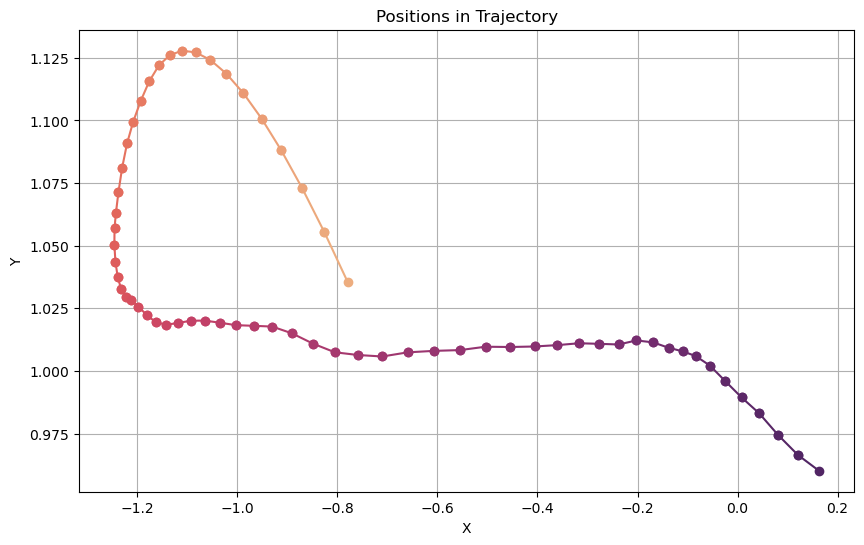

In [6]:
colors = sns.color_palette("flare", len(test_batch))

plt.figure(figsize=(10, 6))
for i in range(len(test_batch) - 1): # Traj plot
    plt.plot(test_batch[0, i:i+2, 0].cpu().numpy(), test_batch[0, i:i+2, 1].cpu().numpy(), color=colors[i], marker='o')
plt.title('Positions in Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()

plt.show()

## FLOW MATCHING

In [9]:
class TrajectoryFlowModel(nn.Module):
    def __init__(self, obs_dim, hidden_dim=128, num_layers=5):
        """
        A neural network that estimates the velocity field for flow matching.
        
        Args:
            obs_dim (int): Dimensionality of observations (D_obs)
            hidden_dim (int): Number of hidden units in the MLP
            num_layers (int): Number of layers in the MLP
        """
        super().__init__()
        
        layers = []
        input_dim = obs_dim + 1  # We include time `t` as an input
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim  # Keep hidden layer size consistent
        
        layers.append(nn.Linear(hidden_dim, obs_dim))  # Output has the same shape as observations
        self.network = nn.Sequential(*layers)

    def forward(self, x, t):
        """
        Forward pass for the trajectory flow model.
        """
        # t_expanded = t[:, None, None].expand(-1, x.shape[1], -1)
        # xt = torch.cat([x, t_expanded], dim=-1).to(device, dtype=torch.float32)
        velocity = self.network(xt) 

        return velocity  # Shape: (N, T, D_obs)

In [11]:
def sample_conditional_pt(x0, x1, t, sigma):
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon 
# sigma * epsilon represents amount of gaussian noise added, epsilon represents Gaussian noise

In [12]:
def compute_conditional_vector_field(x0, x1):
    return x1 - x0

In [13]:
class torch_wrapper(nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        t = t.repeat(x.shape[0])[:, None, None]
        return self.model(x, t)

In [3]:
def plot_trajectories(traj, batch_size):
    """Plot trajectories of some selected samples."""
    print(f"Plot trajs: traj shape {traj.shape}")
    n = batch_size  # Batch_size
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="orange")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
    plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
    plt.xticks([])
    plt.yticks([])
    plt.title("Flow Matching Evolution")
    plt.grid()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [15]:
def single_gaussian_sample_alt(batch_size, sec_dim, traj_dim , device=device, var=1.0):
    """
    Generate samples from a single Gaussian distribution centered at the origin.

    Args:
        batch_size (int): Number of batches.
        sec_dim (int): Number of sections (sequence length).
        traj_dim (int): Dimensionality of each trajectory point.
        var (float): Variance of the Gaussian distribution.

    Returns:
        torch.Tensor: Tensor of shape (n, dim) containing sampled points.
    """
    single_sample = torch.randn(batch_size, sec_dim, traj_dim) * var**0.5
    return single_sample.to(device, dtype=torch.float32)

In [16]:
def sample_and_plot(flow_model, batch_size, xt, traj_dim):
    node = NeuralODE(
        torch_wrapper(flow_model), solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )
    with torch.no_grad():
        traj = node.trajectory(
            single_gaussian_sample_alt(batch_size, xt.shape[1], traj_dim),
            t_span = torch.linspace(0, 1, 100, device=device, dtype=torch.float32),
        )
        plot_trajectories(traj.cpu().numpy(), batch_size)

## Training

Training Progress: 100%|██████████| 5/5 [16:26<00:00, 197.38s/it]
/cluster/home/mortenhs/.conda/envs/fm_env/lib/python3.12/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


Plot trajs: traj shape (100, 64, 178, 4)


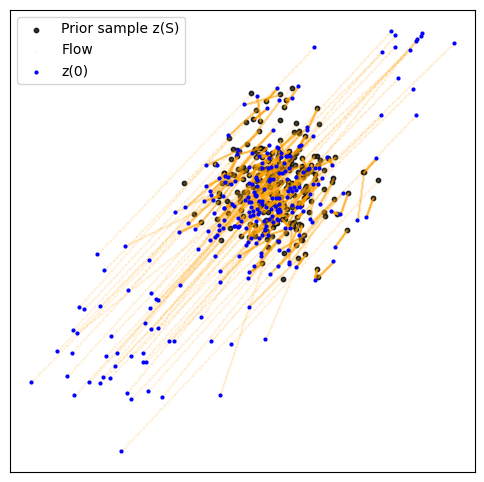

In [17]:
from torchdyn.core import NeuralODE

model_path = "fm_model.pt"
epochs = 5
lr = 3e-3 # Learning rate

sigma = 0.1
traj_dim = 4 # [xpos, ypos, xvel, yvel]
flow_model = TrajectoryFlowModel(traj_dim).to(device)
optimizer = torch.optim.AdamW(flow_model.parameters(), lr=lr)

xt_prog = []
losses = []

for i in tqdm(range(epochs), desc="Training Progress"): # Se https://jmtomczak.github.io/blog/18/18_fm.html for kobling til teorien
    for batch in dataLoader:
        observations = batch['observations']
        x1 = observations[torch.randint(observations.size(0), (batch_size, ))].to(device)
        x0 = torch.rand_like(x1).to(device)
        t = torch.rand((x1.shape[0]), device=device)
        
        xt = sample_conditional_pt(x0, x1, t, sigma=0.01).to(device, dtype=torch.float32)  # See eq. (2.3) i guide and code s.5 Prob path
        ut = compute_conditional_vector_field(x0, x1).to(device, dtype=torch.float32) # x1-x0

        # print(f"Shapes xt {xt.shape}, ut {ut.shape}, t_expanded {t_expanded.shape}")

        t_expanded = t[:, None, None].expand(-1, xt.shape[1], -1)
        xt = torch.cat([xt, t_expanded], dim=-1).to(device, dtype=torch.float32)
    
        vt = flow_model(xt, t)
        
        xt_prog.append(xt)

        loss = torch.mean((vt - ut) ** 2)       
        loss = loss.to(device, dtype=torch.float32)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

sample_and_plot(flow_model, batch_size, xt, traj_dim)
# torch.save(flow_model.state_dict(), model_path)

In [2]:
observation_lst = []
max_batches = 100
for count, batch in enumerate(dataLoader):
    if count == max_batches:
        break
    obs = batch['observations']
    observation_lst.append(obs)

plt.figure(figsize=(8, 6))
for observations in observation_lst:
    plt.plot(observations[0, :, 0].cpu().numpy(), observations[0, :, 1].cpu().numpy(), color='g', alpha=0.5)        
plt.title(f'Sampling Progression ODE')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()

NameError: name 'dataLoader' is not defined

# Load model

In [18]:
# # flow_model = TrajectoryFlowModel(obs_dim=4)
# flow_model.load_state_dict(torch.load(model_path, weights_only = True))
# flow_model.eval()

In [20]:
def display_images_in_pairs(save_dir):
    """
    Display images with filenames matching 'sampling_step_*.png' in natural order, two at a time.

    Args:
        save_dir (str): Directory containing the images.
    """
    image_files = natsorted(glob.glob(os.path.join(save_dir, "sampling_step_*.png")))

    for i in range(0, len(image_files), 2):
        plt.figure(figsize=(12, 6))

        for j in range(2):
            if i + j < len(image_files):
                img = plt.imread(image_files[i + j])

                plt.subplot(1, 2, j + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Step {image_files[i + j].split('_')[-1].split('.')[0]}")

        plt.show()

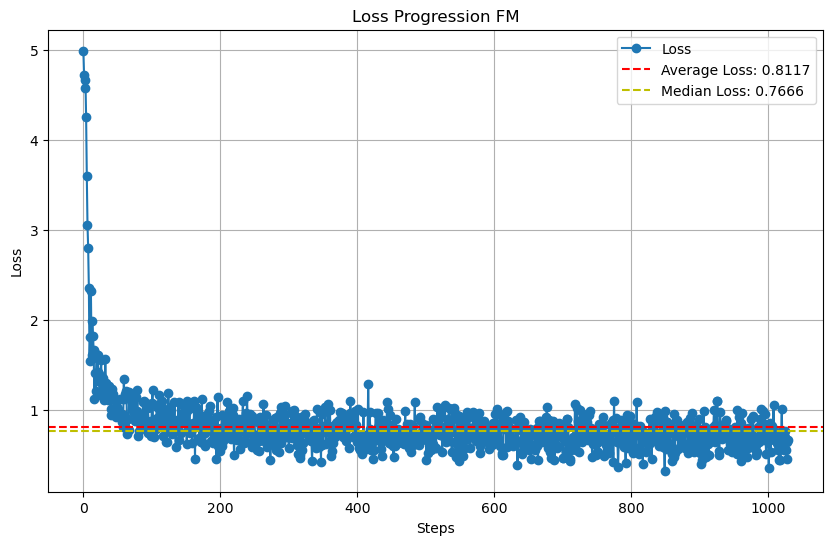

In [24]:
avg_loss = sum(losses)/len(losses)
med_loss = stat.median(losses)

save_dir = 'Plotted loss'
os.makedirs(save_dir, exist_ok=True)
plot_path = os.path.join(save_dir, 'loss_plot.png')

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss', marker='o')
plt.axhline(y=avg_loss, color='r', linestyle='--', label=f'Average Loss: {avg_loss:.4f}')
plt.axhline(y=med_loss, color='y', linestyle='--', label=f'Median Loss: {med_loss:.4f}')
plt.title('Loss Progression FM')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(plot_path)
plt.show()